<a href="https://colab.research.google.com/github/reverentOne/Econ_Projects/blob/main/484project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

# TODO: Need more comments on code
# Out of sample prediction accuracy
# Graph results in some manner (Maybe ROC curve or logit with education?)

In [ ]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/Shared with me/Team_Narwhal-Econ_484_project/Data'
%cd '/content/gdrive/My Drive/Econ 484/Team_Narwhal-Econ_484_project/Data'

Mounted at /content/gdrive
[Errno 2] No such file or directory: '/content/gdrive/Shared with me/Team_Narwhal-Econ_484_project/Data'
/content
/content/gdrive/My Drive/Econ 484/Team_Narwhal-Econ_484_project/Data


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [ ]:
#read in data
df1=pd.read_csv('/content/gdrive/My Drive/Econ 484/Project/train_clean.csv', sep=',')
test_df=pd.read_csv('/content/gdrive/My Drive/Econ 484/Project/test_clean.csv', sep=',')

#Define Variables

In [ ]:
y = df1['term_deposit_yes']
treatments = df1[['education_primary', 'education_secondary', 'education_tertiary']].astype('float64')
# Construct controls with exclusions
all_columns = df1.columns.tolist()
exclude_list = ['term_deposit_yes', 'education_primary', 'education_secondary', 'education_tertiary']
controls_columns = [col for col in all_columns if col not in exclude_list and col != 'Unnamed: 0']
controls = df1[controls_columns].copy()

controls
treatments

,education_primary,education_secondary,education_tertiary
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
35415,0.0,0.0,1.0
35416,0.0,1.0,0.0
35417,0.0,0.0,1.0
35418,1.0,0.0,0.0


#Visualize Control Variables

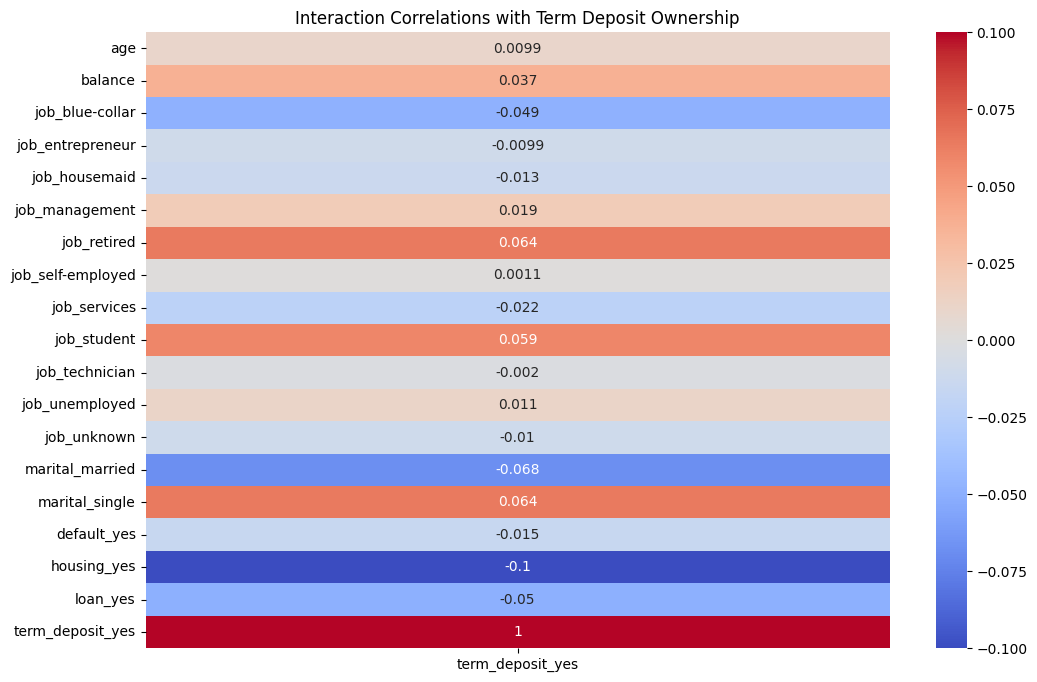

In [ ]:
interaction_correlations = pd.concat([controls , y], axis=1).corr()['term_deposit_yes'] #can replace controls with Xunion after lasso

# Create Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(interaction_correlations.to_frame(), cmap='coolwarm', vmin=-.1, vmax=.1, annot=True)
plt.title('Interaction Correlations with Term Deposit Ownership')
plt.show()

#Simple regression

In [ ]:
for col in treatments.columns:
    logm = LogisticRegression().fit(treatments[[col]], y)
    print("Simple Logit regression ({}): {:.3f}".format(col, logm.coef_[0][0]))

Simple Logit regression (education_primary): -0.306
Simple Logit regression (education_secondary): -0.180
Simple Logit regression (education_tertiary): 0.376


#Add Squared Power Interactions

In [ ]:
# Justification: The positive effect of higher education might plateau.
controls['education_secondary_tertiary_interaction'] = treatments['education_secondary'] * treatments['education_tertiary']

# Justification: There could be specific life phases where financial decision patterns change more drastically (Retirement maybe?)
controls['age_squared'] = controls['age'] ** 2

# Justification: Wealth accumulation source might influence risk behavior.
controls['balance_entrepreneur_interaction'] = controls['balance'] * controls['job_entrepreneur']

# Create control variable interactions (with pre-allocation because it's python)

In [ ]:
controls_columns = controls.columns
control_pairs = list(itertools.combinations(controls_columns, 2))
interaction_results = {}
# Calculate interactions and fill dictionary
for feature_1, feature_2 in control_pairs:
    interaction_column = controls[feature_1] * controls[feature_2]
    interaction_column.fillna(0, inplace=True)
    interaction_results[f"{feature_1}_{feature_2}_interaction"] = interaction_column
interaction_df = pd.DataFrame(interaction_results)
controls = pd.concat([controls, interaction_df], axis=1) # Join interaction terms to the controls DataFrame
controls = controls.drop(controls_columns, axis=1) #Drop original categorical columns

#delete interaction terms with high number of zeros
# print(f"Control variables before .95 non zero cutoff: {controls.shape}")
# zero_threshold = 0.95  # Adjustable
# zero_proportions = (controls.isnull().sum() + (controls == 0).sum()) / len(controls)
# columns_to_drop = zero_proportions[zero_proportions > zero_threshold].index
# controls = controls.drop(columns=columns_to_drop)
# print(f"Control variables after: {controls.shape}")

# Lasso with Cross-Validation

In [ ]:
scaler = StandardScaler()
alphas_to_try = [0.01, 0.1, 0.5, 1, 5, 10, 100]
X=controls
Xnames=X.columns
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=Xnames)
lasso_cv = LassoCV(max_iter=1000,alphas=alphas_to_try).fit(X_scaled, y)
print(f"Alpha selected: {lasso_cv.alpha_}")
# Get selected features by lasso
selected_features = Xnames[lasso_cv.coef_ != 0]
#print(f"Features selected by Lasso for outcome (y): {selected_features}")

# Lasso treatments separately to identify relevant controls
for col in treatments.columns:
    lasso_treatment_cv = LassoCV(cv=5, max_iter=1000, alphas=alphas_to_try).fit(X_scaled, treatments[col])
    selected_controls = Xnames[lasso_treatment_cv.coef_ != 0]
    #print(f"Features selected by Lasso for treatment ({col}): {selected_controls}")

# Form the union of controls (with selected features)
Xunion = X_scaled[selected_features.union(selected_controls)]

print("Number of regressors in the menu: ",len(Xnames))
print("Number of regressors selected by lasso: ",len(Xunion.columns))
# print out accuracy on training and test test
#print("Accuracy on training set: {:.3f}".format(Xunion.score(X_train_scaled,y_train)))
#print("Accuracy on test set: {:.3f}".format(Xunion.score(X_test_scaled,y_test)))
#results = pd.DataFrame({'feature': X.columns[Xunion.coef_!=0],'coefficient': Xunion.coef_[Xunion.coef_!=0]})
#results

Alpha selected: 0.01
Number of regressors in the menu:  210
Number of regressors selected by lasso:  31


#Check for Multicolinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    """
    Calculates the Variance Inflation Factor (VIF) for each feature in the dataset.
    """
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

scaler = StandardScaler()
Z=Xunion
Znames=Z.columns
Z_scaled = pd.DataFrame(scaler.fit_transform(Z), columns=Znames)

print(calculate_vif(Z_scaled))

                                       variables        VIF
0                    age_age_squared_interaction   5.269699
1                        age_balance_interaction   2.033904
2                    age_housing_yes_interaction   3.199965
3                age_job_blue-collar_interaction   3.410045
4               age_job_entrepreneur_interaction   1.301788
5                 age_job_management_interaction   6.651604
6              age_job_self-employed_interaction   1.611851
7                   age_job_services_interaction   2.695140
8                 age_job_technician_interaction   2.139296
9                       age_loan_yes_interaction  22.960803
10               age_marital_married_interaction  46.084539
11                age_marital_single_interaction   3.830496
12            balance_job_management_interaction   1.962541
13         balance_job_self-employed_interaction   1.311665
14            balance_job_technician_interaction   1.445022
15            balance_marital_single_int

# PDS Regression

In [ ]:
omitted_var = 'education_primary'
treatments = treatments.reset_index(drop=True)
Xunion = Xunion.reset_index(drop=True)
rhs = pd.concat([treatments, Xunion], axis=1)
rhs = rhs.drop(omitted_var, axis=1)

# Logistic Regression
logm = LogisticRegression().fit(rhs, y)
print(f"\nRegression results with '{omitted_var}' omitted:\n")

results = pd.DataFrame({'Coefficient': logm.coef_[0],
                        'Odds Ratio': np.exp(logm.coef_[0])},
                       index=rhs.columns)

for index, row in results.iterrows():
    coef, odds_ratio = row['Coefficient'], row['Odds Ratio']
    approx_pct_change = (odds_ratio - 1) * 100
    print(f"- {index}:")
    print(f"   Coefficient: {coef:.3f}")
    print(f"   Odds Ratio: {odds_ratio:.2f}")
    print(f"   Approximate % Change in Odds: {approx_pct_change:.1f}%")


Regression results with 'education_primary' omitted:

- education_secondary:
   Coefficient: 0.242
   Odds Ratio: 1.27
   Approximate % Change in Odds: 27.4%
- education_tertiary:
   Coefficient: 0.515
   Odds Ratio: 1.67
   Approximate % Change in Odds: 67.3%
- age_age_squared_interaction:
   Coefficient: 0.125
   Odds Ratio: 1.13
   Approximate % Change in Odds: 13.3%
- age_balance_interaction:
   Coefficient: 0.018
   Odds Ratio: 1.02
   Approximate % Change in Odds: 1.8%
- age_housing_yes_interaction:
   Coefficient: -0.314
   Odds Ratio: 0.73
   Approximate % Change in Odds: -26.9%
- age_job_blue-collar_interaction:
   Coefficient: -0.118
   Odds Ratio: 0.89
   Approximate % Change in Odds: -11.1%
- age_job_entrepreneur_interaction:
   Coefficient: -0.040
   Odds Ratio: 0.96
   Approximate % Change in Odds: -3.9%
- age_job_management_interaction:
   Coefficient: -0.149
   Odds Ratio: 0.86
   Approximate % Change in Odds: -13.8%
- age_job_self-employed_interaction:
   Coefficient:

In [ ]:
# Accuracy test
X_test = test_df.drop(columns=[omitted_var, 'y'])
y_test = test_df['y']

# Scale the test data using the same scaler fit on the training data
X_test_scaled = scaler.transform(X_test)

# Predict probabilities
probabilities = logm.predict_proba(X_test_scaled)[:, 1]


KeyError: "['y'] not found in axis"

#Visualization

In [ ]:
# Concatenate controls with the dependent variable
full_data = pd.concat([controls, y], axis=1)

# Create Heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(interaction_correlations, cmap='coolwarm', vmin=-.1, vmax=.1, annot=True, center=0)
plt.title('Interaction Correlations with Term Deposit Ownership')
plt.show()


IndexError: Inconsistent shape between the condition and the input (got (19, 1) and (19,))

<Figure size 2000x1600 with 0 Axes>

My Analysis:



#Debiased robustness checks with machine learning

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import KFold
import statsmodels.api as sm

In [ ]:
d = treatments
lassoy = linear_model.LassoCV().fit(X, y)
yresid=y-lassoy.predict(X)
lassod = linear_model.MultiTaskLassoCV().fit(X, d)
dresid=d-lassod.predict(X)

In [ ]:
dmlreg=linear_model.LinearRegression().fit(dresid,yresid)
print("{:.3f}".format(dmlreg.coef_[0]))

-0.024


In [ ]:
# create our sample splitting "object"
kf = KFold(n_splits=5,shuffle=True,random_state=42)

# apply the splits to our Xs
kf.get_n_splits(X)

# initialize columns for residuals
yresid = y*0
dresid = d*0

# Now loop through each fold
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  d_train, d_test = d.iloc[train_index,:], d.iloc[test_index,:]

  # Do DML thing
  # Lasso y on training folds:
  lassoy.fit(X_train, y_train)

  # but get residuals in test set
  yresid.iloc[test_index]=y_test-lassoy.predict(X_test)

  #Lasso d on training folds
  lassod.fit(X_train, d_train)

  #but get residuals in test set
  dresid.iloc[test_index,:]=d_test-lassod.predict(X_test)


# Regress resids
dmlreg=linear_model.LinearRegression().fit(dresid,yresid)

print("{:.3f}".format(dmlreg.coef_[0]))

DML regression earnings race gap: -0.024


In [ ]:


# Define K-Folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Preparing storage for coefficients
coefs = []

# Start the K-Fold process
for train_index, test_index in kf.split(df1):
    # Split data
    X_train, X_test = controls.iloc[train_index], controls.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    treatment_train, treatment_test = treatments.iloc[train_index], treatments.iloc[test_index]

    # Standardize controls
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Lasso regression to select features and predict nuisance parameters
    lasso_controls = LassoCV(cv=5, alphas=[0.01, 0.1, 0.5, 1, 5, 10, 100]).fit(X_train_scaled, y_train)
    predicted_controls_train = lasso_controls.predict(X_train_scaled)
    predicted_controls_test = lasso_controls.predict(X_test_scaled)

    # Orthogonalize treatments and outcome
    residual_y_train = y_train - predicted_controls_train
    residual_y_test = y_test - predicted_controls_test

    # Fit treatment effects model
    treatment_model = sm.OLS(residual_y_train, sm.add_constant(treatment_train)).fit()
    coefs.append(treatment_model.params)

    # Optionally, test model
    treatment_preds = treatment_model.predict(sm.add_constant(treatment_test))
    #Assess the predictions here (e.g., through metrics or plots)

# Average coefficients across folds
average_coefs = np.mean(coefs, axis=0)
print("Averaged coefficients across folds:", average_coefs)


Averaged coefficients across folds: [ 9.64686228e+10 -9.64686228e+10 -9.64686228e+10 -9.64686228e+10]
